#  Обучение Vision Transformer

 реализация ViT датасет CIFAR-10.

 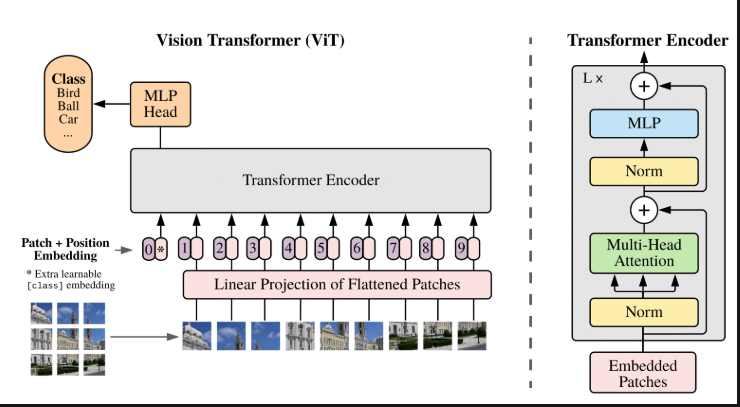 
 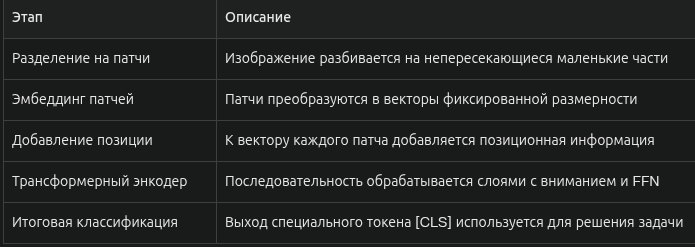 

Разбиение изображений CIFAR-10 (32×32) на патчи 4×4,  

Создание патч-эмбеддингов,  

Трансформерный энкодер с Multi-Head Self Attention и Feed Forward,  

Классификационный слой.  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Параметры
image_size = 32
patch_size = 8
num_classes = 10
embed_dim = 128
num_heads = 8
num_layers = 8
mlp_dim = 256
dropout = 0.1

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (batch, 3, H, W)
        x = self.proj(x)  # (batch, embed_dim, n_patches_sqrt, n_patches_sqrt)
        x = x.flatten(2)  # (batch, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch, n_patches, embed_dim)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: (seq_len, batch, embed_dim)
        x2 = self.norm1(x)
        attn_output, _ = self.attn(x2, x2, x2)
        x = x + attn_output
        x2 = self.norm2(x)
        x = x + self.mlp(x2)
        return x

class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, embed_dim, num_heads, num_layers, mlp_dim, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (img_size // patch_size)**2 + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Инициализация параметров
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embed(x)  # (batch, n_patches, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch, 1 + n_patches, embed_dim)
        x = x + self.pos_embed
        x = self.dropout(x)

        # PyTorch MultiheadAttention ожидает (seq_len, batch, embed_dim)
        x = x.transpose(0, 1)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(0, 1)  # (batch, seq_len, embed_dim)
        x = self.norm(x)
        cls_output = x[:, 0]  # (batch, embed_dim)
        out = self.head(cls_output)
        return out


model = ViT(
    img_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim,
    dropout=dropout,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



## 4. Подготовка датасета



In [2]:

import torch
import torchvision
import torchvision.transforms as transforms



def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    # Трансформации для обучающего датасета
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),  # случайный кроп с масштабированием
        transforms.RandomHorizontalFlip(),  # случайное горизонтальное отражение
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)

    if train_sample_size is not None:
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    # Трансформации для тестового датасета
    test_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=test_transform)

    if test_sample_size is not None:
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    return trainloader, testloader


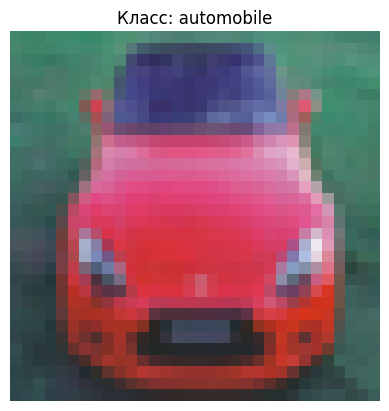

In [3]:
import random
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

transform = transforms.ToTensor()

# Загружаем тестовый датасет 
dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#  случайный индекс
index = random.randint(0, len(dataset) - 1)
image, label = dataset[index]

# классы
classes = dataset.classes

plt.imshow(image.permute(1, 2, 0)) 
plt.title(f"Класс: {classes[label]}")
plt.axis("off")
plt.show()


# обучение!

Epoch [1/10] | Train Loss: 1.9279 | Train Acc: 0.2737 | Test Loss: 1.7966 | Test Acc: 0.3195


Epoch [2/10] | Train Loss: 1.7779 | Train Acc: 0.3407 | Test Loss: 1.6850 | Test Acc: 0.3925


Epoch [3/10] | Train Loss: 1.7089 | Train Acc: 0.3691 | Test Loss: 1.5858 | Test Acc: 0.4180


Epoch [4/10] | Train Loss: 1.6536 | Train Acc: 0.3949 | Test Loss: 1.5272 | Test Acc: 0.4468


Epoch [5/10] | Train Loss: 1.6036 | Train Acc: 0.4133 | Test Loss: 1.4745 | Test Acc: 0.4682


Epoch [6/10] | Train Loss: 1.5526 | Train Acc: 0.4338 | Test Loss: 1.4698 | Test Acc: 0.4692


Epoch [7/10] | Train Loss: 1.5137 | Train Acc: 0.4525 | Test Loss: 1.4072 | Test Acc: 0.4917


Epoch [8/10] | Train Loss: 1.4823 | Train Acc: 0.4645 | Test Loss: 1.3568 | Test Acc: 0.5099


Epoch [9/10] | Train Loss: 1.4518 | Train Acc: 0.4732 | Test Loss: 1.3420 | Test Acc: 0.5127


Epoch [10/10] | Train Loss: 1.4290 | Train Acc: 0.4827 | Test Loss: 1.3326 | Test Acc: 0.5196
Best Test Accuracy: 0.5196


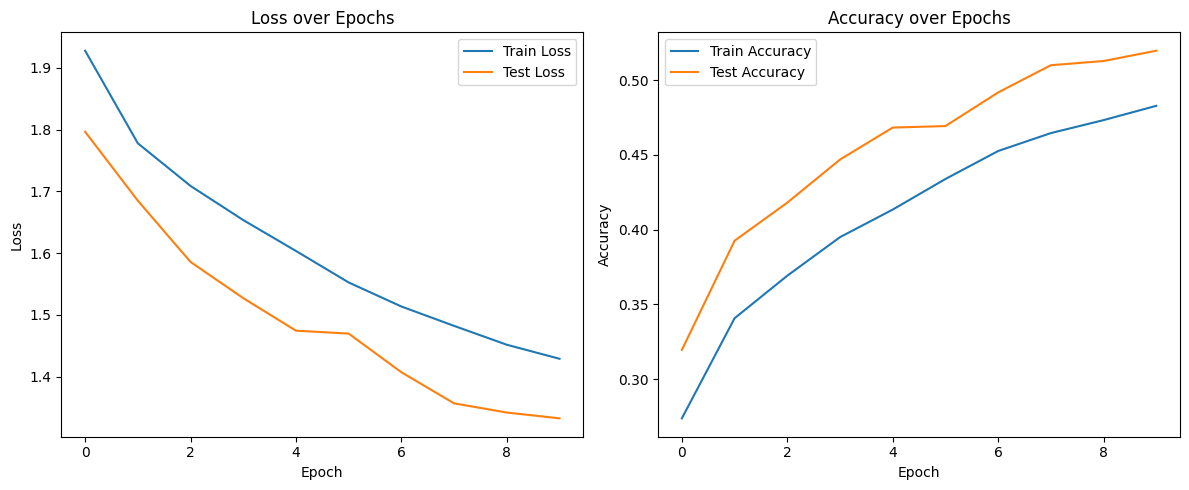

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

class Trainer:
    def __init__(self, model, optimizer, scheduler, loss_fn, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.device = device


    def train(self, trainloader, testloader, epochs):
        best_accuracy = 0
        best_model_state = None

        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0

            loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * images.size(0)

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += images.size(0)

                loop.set_postfix(loss=loss.item(), acc=correct / total)

            train_loss = total_loss / len(trainloader.dataset)
            train_acc = correct / total
            self.scheduler.step()

            test_acc, test_loss = self.evaluate(testloader)
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | "
                f"Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_model_state = copy.deepcopy(self.model.state_dict())

        print(f"Best Test Accuracy: {best_accuracy:.4f}")
        if best_model_state:
            self.model.load_state_dict(best_model_state)

        self.plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)




    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0

        for images, labels in testloader:
            images, labels = images.to(self.device), labels.to(self.device)
            logits = self.model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * images.size(0)

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)
        return accuracy, avg_loss

    def plot_metrics(self, train_losses, train_accuracies, test_losses, test_accuracies):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Train Accuracy")
        plt.plot(test_accuracies, label="Test Accuracy")
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()



def main():
    batch_size = 64
    epochs = 10
    lr = 1e-3

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trainloader, testloader = prepare_data(batch_size=batch_size)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()

    trainer = Trainer(model, optimizer, scheduler, loss_fn, device)
    trainer.train(trainloader, testloader, epochs)


if __name__ == '__main__':
    main()
